In [1]:
# Define the system to generate data for
system = 'pendulum'  # Possible values: 'pendulum', 'quadratic', 'duffing', simple

In [2]:
%matplotlib notebook
import numpy as np
import sys
from scipy.integrate import solve_ivp    
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1)
import inspect

from utils.control_functions import compute_control_input

# Generate trajectories of motion

This notebook generates a dataset of trajectories

In [3]:
## Choose parameters:
dt = 0.02
N  = 51 # Number of timesteps

## Choose your dynamics:

In [4]:
if system == 'quadratic':
    from systems.dynamics_functions import quadratic_attracting_manifold_dynamics
    from systems.models import model_quadratic_attracting_manifold

    # Define the quadratic attracting manifold model
    model = model_quadratic_attracting_manifold()

    # Define the quadratic attracting manifold dynamics
    fn = quadratic_attracting_manifold_dynamics

    # Define the ranges of the initial conditions
    initial_conditions_min = np.array([-0.5, -0.5])
    initial_conditions_max = np.array([0.5, 0.5])

    # Define the control type
    control = 'none'  # Possible values: 'none', 'pd'
    target_state = np.array([0,0])
    gains = {'Kp': 10, 'Kd': 3}
    
    # Define the potential function to compute the potential of the system (uses a Lyapunov function, but not verified)
    potential = lambda x, y: 0.5 * model['mu'] * x**2 + 0.5 * model['lambda'] * y**2 - (1/3) * x**3

    # Set ignore_potential to False by default
    ignore_potential = True

elif system == 'pendulum':
    from systems.dynamics_functions import pendulum_dynamics
    from systems.models import model_pendulum

    # Define the non-linear pendulum model
    model = model_pendulum()

    # Define the non-linear pendulum dynamics
    fn = pendulum_dynamics

    # Define the ranges of the initial conditions
    initial_conditions_min = np.array([-np.pi, -2])
    initial_conditions_max = np.array([np.pi, 2])
    
    # Define the control type
    control = 'none'  # Possible values: 'none', 'pd'
    target_state = np.array([np.pi,0])
    gains = {'Kp': 10, 'Kd': 3}

    # Define the potential function to check if the pendulum swings over the top, taking in account length and mass and G
    potential = lambda x, y: (1/2) * model['M'] * model['L']**2 * y**2 \
                             - model['M'] * model['G'] * model['L'] * np.cos(x) \
                             - model['mu'] * model['M'] * model['L']**2 * y**2 / (2 * model['G'])

    # Set ignore_potential to False by default
    ignore_potential = False
    
elif system == 'duffing':
    from systems.dynamics_functions import duffing_oscillator
    from systems.models import model_duffing_oscillator

    # Define the non-linear pendulum model
    #model = model_duffing_oscillator()
    model = model_duffing_oscillator(alpha=-1,beta=0)
    #model = model_duffing_oscillator(alpha=1, beta=1, delta=0.2, gamma=0.3, omega=1) # an interesting complex case
    
    # Define the non-linear pendulum dynamics
    fn = duffing_oscillator

    # Define the ranges of the initial conditions
    initial_conditions_min = np.array([-2, -2])
    initial_conditions_max = np.array([2, 2])

    # Define the control type
    control = 'none'  # Possible values: 'none', 'pd'
    target_state = np.array([np.pi,0])
    gains = {'Kp': 10, 'Kd': 3}

    # Define the potential function 
    potential = lambda x, y:  0.5 * model['alpha'] * x**2 + 0.25 * model['beta'] * x**4

    # Set ignore_potential to False by default
    ignore_potential = True

# Function to generate the state sequences

In [5]:
# Define a function to simulate a trajectory of the system
def simulate_trajectory(x0, N, fn, model, compute_control_input, dt):
    # Simulate the dynamics using solve_ivp
    t = np.zeros(N)  # timesteps
    u = np.zeros(N)  # control
    x = np.zeros((x0.shape[0], N))  # state
    x[:, 0] = x0

    # Define the ODE function for solve_ivp
    def ode_func(t, x):
        u = compute_control_input(x, target_state, control_type=control, gains=gains)
        if 't' in inspect.signature(fn).parameters:  # Check if fn takes t as an argument
            return fn(x, t, u, model)
        else:
            return fn(x, u, model)

    t_span = [0, (N-1)*dt]
    sol = solve_ivp(ode_func, t_span, x[:, 0], t_eval=np.linspace(*t_span, N))
    x = sol.y

    # Compute the control inputs for returning the trajectory
    for n in range(N):
        u[n] = compute_control_input(x[:, n], target_state, control_type=control, gains=gains)
        t[n] = n * dt

    return x, u

# Define a function to generate random trajectories of the system
def generate_random_trajectories(n_samples, fn, model, compute_control_input, dt, initial_conditions_min, initial_conditions_max, N, ignore_potential=False):
    X = []
    for i in range(n_samples):
        # Generate a random initial condition, either ignoring or checking the potential
        if ignore_potential:
            x0 = np.random.uniform(low=initial_conditions_min, high=initial_conditions_max, size=len(initial_conditions_min))
        else:
            valid_swing = False
            while not valid_swing:
                x0 = np.random.uniform(low=initial_conditions_min, high=initial_conditions_max, size=len(initial_conditions_min))
                if potential(x0[0], x0[1]) < 1:
                    valid_swing = True
        # Simulate the trajectory using the generated initial condition
        x, u = simulate_trajectory(x0, N, fn, model, compute_control_input, dt)
        X.append(np.vstack([x, u]).T)
    return np.array(X)

# Visualise some examples

<IPython.core.display.Javascript object>


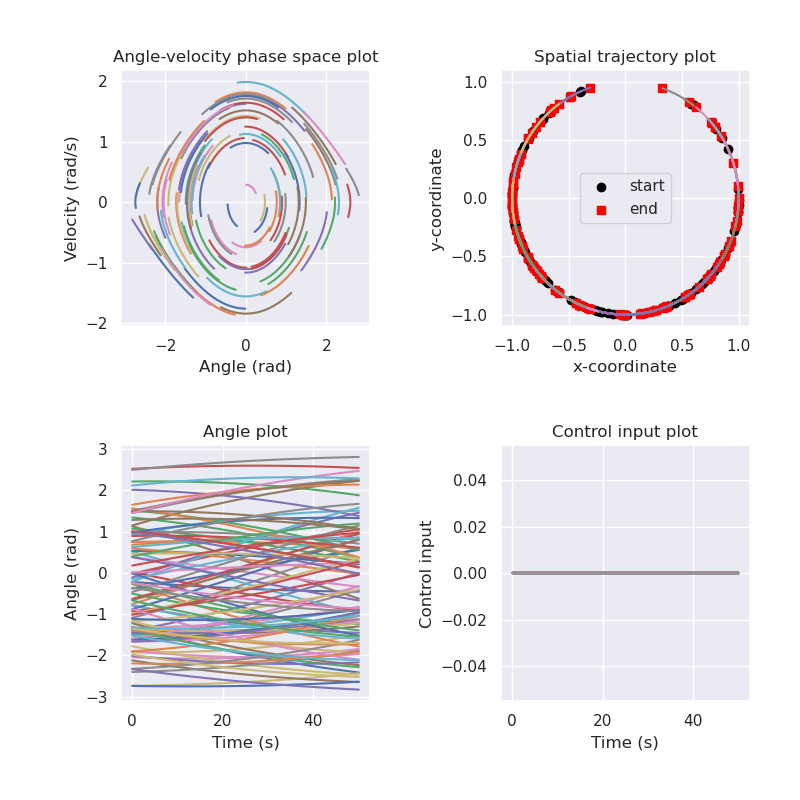

In [6]:
# Set the number of trajectories to generate
N_traj = 100

# Generate random test trajectories
X_test = generate_random_trajectories(N_traj, fn, model, compute_control_input, dt, initial_conditions_min, initial_conditions_max, N, ignore_potential)

# Plot the test trajectories
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

# Angle-velocity phase space plot
axs[0,0].plot(X_test[:,:,0].T, X_test[:,:,1].T)
axs[0,0].set_xlabel('Angle (rad)'), axs[0,0].set_ylabel('Velocity (rad/s)')
axs[0,0].set_title('Angle-velocity phase space plot')

if system == 'pendulum':
    # Spatial trajectory plot
    r = np.empty((N_traj, X_test.shape[1], 2))
    r[:,:,0] = np.sin(X_test[:,:,0]) * model['L']
    r[:,:,1] = -np.cos(X_test[:,:,0]) * model['L']
    axs[0,1].plot(r[:,:,0].T, r[:,:,1].T)
    axs[0,1].scatter(r[:,0,0], r[:,0,1], marker='o', color='black', label='start')
    axs[0,1].scatter(r[:,-1,0], r[:,-1,1], marker='s', color='red', label='end')
    axs[0,1].set_xlim([-model['L']-.1, model['L']+.1])
    axs[0,1].set_ylim([-model['L']-.1, model['L']+.1])
    axs[0,1].set_xlabel('x-coordinate'), axs[0,1].set_ylabel('y-coordinate')
    axs[0,1].set_title('Spatial trajectory plot')
    axs[0,1].legend()

# Angle plot
axs[1,0].plot(X_test[:,:,0].T)
axs[1,0].set_xlabel('Time (s)'), axs[1,0].set_ylabel('Angle (rad)')
axs[1,0].set_title('Angle plot')

# Control input plot
axs[1,1].plot(X_test[:,:,2].T, alpha=0.2)
axs[1,1].set_xlabel('Time (s)'), axs[1,1].set_ylabel('Control input')
axs[1,1].set_title('Control input plot')

# Adjust spacing between subplots
fig.tight_layout(pad=3.0)

# Save to file incrementally

In [7]:
import h5py
import numpy as np

num_train = 15000
num_test = 3000
num_valid = 1000
batch_size = 100

def save_state_to_file(name, num_samples):
    """
    Save state trajectories to an HDF5 file.

    Parameters:
    name (str): Name of the HDF5 file.
    num_samples (int): Total number of samples to generate.

    Returns:
    None
    """
    with h5py.File(f"./data/{name}.hdf5", 'a') as f:
        # Generate and save state trajectories in batches
        for i, _ in enumerate(range(0, num_samples, batch_size)):
            # Generate a batch of state trajectories
            X_states = generate_random_trajectories(batch_size, fn, model, compute_control_input, dt, initial_conditions_min, initial_conditions_max, N, ignore_potential)

            # Create the dataset or append to it
            if i == 0:
                f.create_dataset("state_time", data=X_states[:, :N-1], chunks=True,
                                  maxshape=(None, N-1, X_states.shape[2]))
                f.create_dataset("state_time_plus_1", data=X_states[:, 1:], chunks=True,
                                  maxshape=(None, N-1, X_states.shape[2]))
            else:
                # Expand the dataset and add new data to it              
                f['state_time'].resize((f['state_time'].shape[0] + X_states.shape[0]), axis=0)
                f['state_time'][-X_states.shape[0]:] = X_states[:,:N-1]
                f['state_time_plus_1'].resize((f['state_time_plus_1'].shape[0] + X_states.shape[0]), axis=0)
                f['state_time_plus_1'][-X_states.shape[0]:] = X_states[:,1:]      

save_state_to_file('train', num_train)
save_state_to_file('test', num_test)
save_state_to_file('valid', num_valid)

# Generate longer trajectories for evaluating long term predictions

In [8]:
def generate_delay_list(x0, N):
    """
    Generate a sequential list of delay coordinates from an initial starting point.

    Parameters:
    x0 (ndarray): Initial state vector.
    N (int): Number of delay coordinates to generate.

    Returns:
    ndarray: Array of delay coordinates.
    """
    X = []
    x, u = simulate_trajectory(x0, N, fn, model, compute_control_input, dt)
    X.append(np.vstack([x, u]).T) # Add the control signal as the final column (even if u=0, we can just ignore later)
    return np.array(X)

# Visualise across the space

<IPython.core.display.Javascript object>


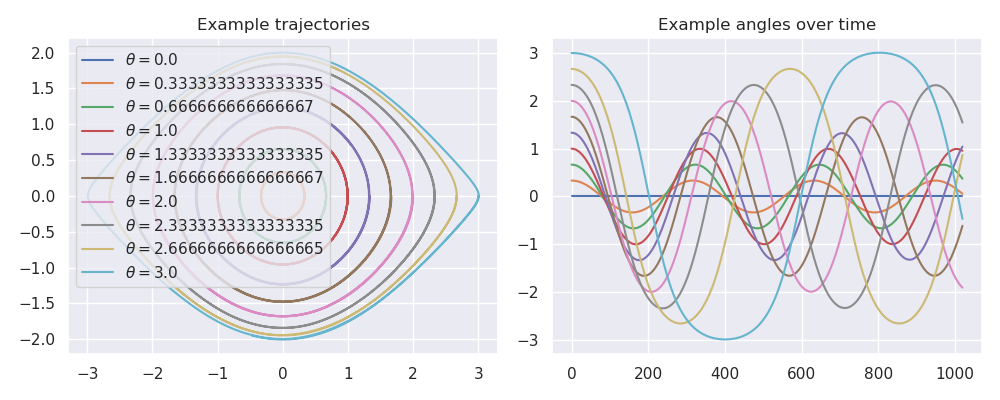

In [9]:
N_long = int(N * 20)

# Generate delay coordinates for the pendulum starting from different initial conditions
if system == 'pendulum':
    initial_condition_start = np.array([3, 0])
    initial_condition_end = np.array([0, 0])
elif system == 'quadratic':
    initial_condition_start = np.array([0.5, 0])
    initial_condition_end = np.array([0, 0])
elif system == 'duffing':
    initial_condition_start = np.array([-1.5, 0])
    initial_condition_end = np.array([1.5, 0])
    
# Generate trajectories every x degrees    
number_of_trajectories = 10
X_states_list=[]    
for angle in np.linspace(initial_condition_start[0],initial_condition_end[0],number_of_trajectories)[::-1]:
    X_states_list.append(generate_delay_list(np.array([angle,0]), N_long))

# Plot example trajectories and angles over time
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for X_state in X_states_list:
    axs[0].plot(X_state[0, :, 0], X_state[0, :, 1], label=r'$\theta={}$'.format(X_state[0,0,0]))
    axs[1].plot(X_state[0, :, 0])
axs[0].set_title('Example trajectories')
axs[0].legend()
axs[1].set_title('Example angles over time')
fig.tight_layout()

# Extract a sliding window of delay coordinates for each trajectory
X_states_list_array = []
for X_state in X_states_list:
    X_states_list_array.append(np.array([X_state[0, i:i+N, :] for i in range(N_long-N)]))
X_states_list_array = np.array(X_states_list_array)

# Save to file incrementally

In [10]:
def save_long_traj(name,X_states):
    """
    Save the delay coordinates of a trajectory to an HDF5 file.

    Parameters:
    X_states (ndarray): Array of delay coordinates.
    name (str): Name of the HDF5 file.

    Returns:
    None
    """
    with h5py.File(f"./data/{name}.hdf5", "a") as f:
        if "state_time" in f:
            del f["state_time"]
        if "state_time_plus_1" in f:
            del f["state_time_plus_1"]
        f.create_dataset("state_time", data=X_states[:,:, :N-1], chunks=True)#, maxshape=(None,number_of_trajectories, N-1, X_states.shape[3]))
        f.create_dataset("state_time_plus_1", data=X_states[:,:, 1:], chunks=True)#, maxshape=(None,number_of_trajectories, N-1, X_states.shape[3]))

save_long_traj('long_trajectories'.format(number_of_trajectories),X_states_list_array)